In [4]:
#Dependencies and Setup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress

In [5]:
import csv

from pymongo import MongoClient

DB_NAME = 'worldHappiness'
FIG_COLLECTION_NAME = 'fig'
TABLE_COLLECTION_NAME = 'table'
FIG_DATA_FILENAME = 'resources/world-happiness-fig-2024.csv'
TABLE_DATA_FILENAME = 'resources/world-happiness-table-2024.csv'

mongo = MongoClient(port=27017)


def load_csv_data(filename):
    with open(filename, 'r', encoding='utf-8-sig') as fig_data_file:
        reader = csv.reader(fig_data_file)
        raw_data = list(reader)
        header, rows = raw_data[0], raw_data[1:]
        data = [
            {key: value for key, value in zip(header, row)}
            for row in rows
        ]
    parsed_data = []
    for row in data:
        parsed_row = {}
        for key, value in row.items():
            try:
                if key == 'year':
                    value = int(value)
                else:
                    value = float(value)
            except:
                pass
            parsed_row[key] = value
        parsed_data.append(parsed_row)
    return parsed_data


def insert_into_mongo(data, db_name, collection_name):
    db = mongo[db_name]
    collection = db[collection_name]
    collection.insert_many(data)


def import_data():
    insert_into_mongo(load_csv_data(FIG_DATA_FILENAME), DB_NAME,
                      FIG_COLLECTION_NAME)
    insert_into_mongo(load_csv_data(TABLE_DATA_FILENAME), DB_NAME,
                      TABLE_COLLECTION_NAME)


if __name__ == '__main__':
    import_data()


In [8]:
def mongo_to_pandas(db_name, collection_name):
    # Create a MongoDB client
    client = MongoClient('mongodb://localhost:27017/')
    
    # Access the database and collection
    db = client[db_name]
    collection = db[collection_name]
    
    # Convert the collection to a DataFrame
    df = pd.DataFrame(list(collection.find()))
    
    return df

In [9]:
# Convert 'fig' collection to pandas DataFrame
fig_df = mongo_to_pandas(DB_NAME, FIG_COLLECTION_NAME)
# print("FIG DataFrame:")
# print(fig_df.head())
    
# Convert 'table' collection to pandas DataFrame
table_df = mongo_to_pandas(DB_NAME, TABLE_COLLECTION_NAME)
print("\nTABLE DataFrame:")
print(table_df.head())



TABLE DataFrame:
                        _id Country name  year  Life Ladder  \
0  6705e22950eae86cdae93739  Afghanistan  2008        3.724   
1  6705e22950eae86cdae9373a  Afghanistan  2009        4.402   
2  6705e22950eae86cdae9373b  Afghanistan  2010        4.758   
3  6705e22950eae86cdae9373c  Afghanistan  2011        3.832   
4  6705e22950eae86cdae9373d  Afghanistan  2012        3.783   

  Log GDP per capita Social support Healthy life expectancy at birth  \
0               7.35          0.451                             50.5   
1              7.509          0.552                             50.8   
2              7.614          0.539                             51.1   
3              7.581          0.521                             51.4   
4              7.661          0.521                             51.7   

  Freedom to make life choices Generosity Perceptions of corruption  \
0                        0.718      0.164                     0.882   
1                        0.6

In [10]:
country_counts = table_df['Country name'].value_counts()
country_counts

Country name
Lebanon      180
Jordan       180
Nicaragua    180
Nepal        180
Moldova      180
            ... 
Cuba          10
Suriname      10
Guyana        10
Oman          10
Maldives      10
Name: count, Length: 165, dtype: int64

In [18]:
#Converting variables to Numbers 
table_df['Healthy life expectancy at birth'] = pd.to_numeric(table_df['Healthy life expectancy at birth'], errors='coerce')
table_df['Life Ladder'] = pd.to_numeric(table_df['Life Ladder'], errors='coerce')
table_df['Perceptions of corruption'] = pd.to_numeric(table_df['Perceptions of corruption'], errors='coerce')
table_df['Freedom to make life choices'] = pd.to_numeric(table_df['Freedom to make life choices'], errors='coerce')
table_df['Generosity'] = pd.to_numeric(table_df['Generosity'], errors='coerce')
table_df['Positive affect'] = pd.to_numeric(table_df['Positive affect'], errors='coerce')
table_df['Social support'] = pd.to_numeric(table_df['Social support'], errors='coerce')
table_df['Negative affect'] = pd.to_numeric(table_df['Negative affect'], errors='coerce')

The correlation between Perceptions of corruption and Freedom to make life choices is -0.51


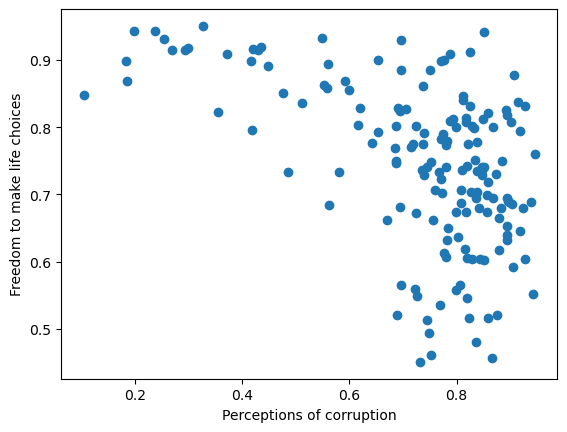

In [19]:
# Generating Correlation and Regression plot of Percentions of corruption and Freedom to make life choices

# Now you can group by 'Country name' and calculate the mean
x_values = table_df.groupby("Country name")["Perceptions of corruption"].mean()
y_values = table_df.groupby("Country name")["Freedom to make life choices"].mean()

# Drop NaN values
valid_data = pd.concat([x_values, y_values], axis=1).dropna()
x_values_clean = valid_data.iloc[:, 0]
y_values_clean = valid_data.iloc[:, 1]

correlation = st.pearsonr(x_values_clean, y_values_clean)
print(f"The correlation between Perceptions of corruption and Freedom to make life choices is {round(correlation[0],2)}")

slope, intercept, rvalue, pvalue, stderr = linregress(x_values_clean, y_values_clean)
regress_values = x_values_clean * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_values_clean, y_values_clean)
# plt.plot(x_values_clean, regress_values, "r-")
# plt.annotate(line_eq, (0.1, 0.5), fontsize = 15, color="red")
plt.xlabel("Perceptions of corruption")
plt.ylabel("Freedom to make life choices")
plt.show()

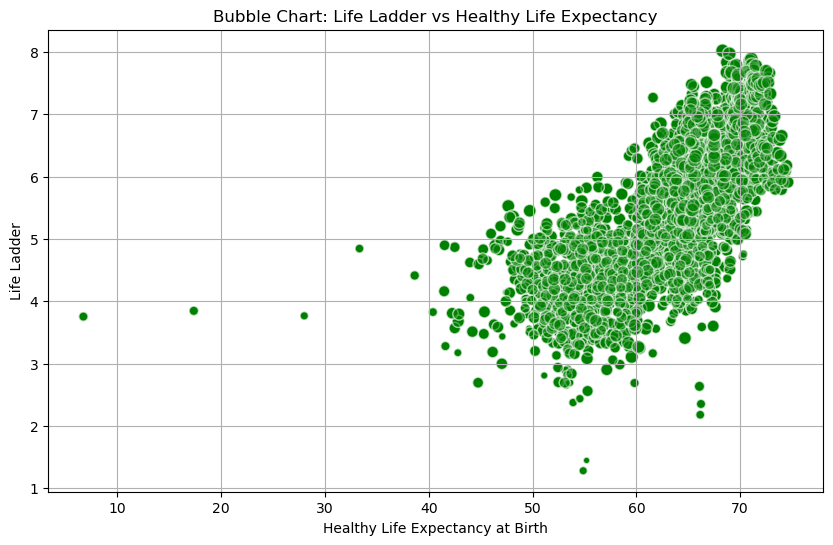

In [20]:
#Bubble chart to represent "Life Ladder" against "Healthy life expectancy at birth," where the size of the bubbles can represent "Freedom to make life choices." 

x_values = table_df["Healthy life expectancy at birth"]
y_values = table_df["Life Ladder"]
s = table_df["Freedom to make life choices"]*100  # bubble size (scaled for visibility)

plt.figure(figsize=(10,6))
plt.scatter(x_values, y_values, s, alpha=0.5, c="green", edgecolors="w")

#Adding titles and labels
plt.title("Bubble Chart: Life Ladder vs Healthy Life Expectancy")
plt.xlabel("Healthy Life Expectancy at Birth")
plt.ylabel("Life Ladder")
plt.grid(True)
plt.show()


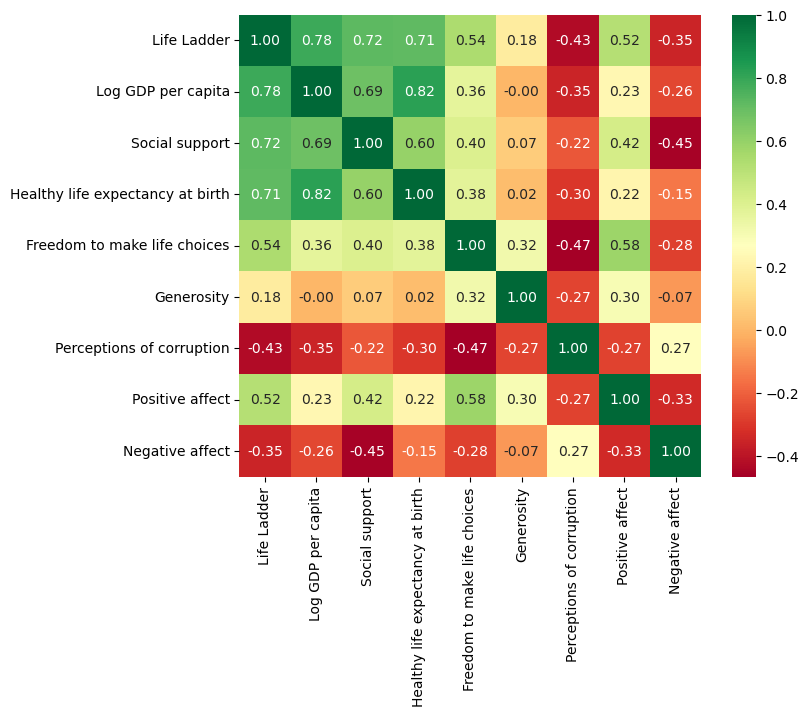

In [26]:
#Heatmap to show the correlation between "Generosity," "Perceptions of corruption," and "Positive affect." 

#Calculating the correlation matrix
corr_matrix = table_df[['Life Ladder','Log GDP per capita','Social support','Healthy life expectancy at birth',
                        'Freedom to make life choices','Generosity','Perceptions of corruption','Positive affect','Negative affect']].corr()

#Creating the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt='.2f', square=True)
# plt.title('Correlation Heatmap')
plt.show()

The correlation between Log GDP per capita and Life Ladder is 0.83


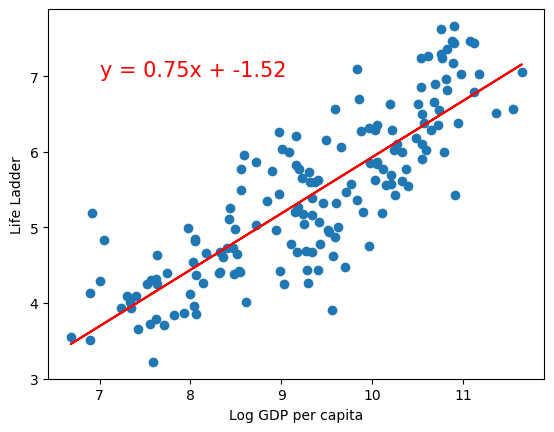

In [27]:
# Generating Correlation and Regression plot of Log GPD per capita and Life Ladder
table_df['Log GDP per capita'] = pd.to_numeric(table_df['Log GDP per capita'], errors='coerce')

# Now you can group by 'Country name' and calculate the mean
x_values = table_df.groupby("Country name")["Log GDP per capita"].mean()
y_values = table_df.groupby("Country name")["Life Ladder"].mean()

# Drop NaN values
valid_data = pd.concat([x_values, y_values], axis=1).dropna()
x_values_clean = valid_data.iloc[:, 0]
y_values_clean = valid_data.iloc[:, 1]

correlation = st.pearsonr(x_values_clean, y_values_clean)
print(f"The correlation between Log GDP per capita and Life Ladder is {round(correlation[0],2)}")

slope, intercept, rvalue, pvalue, stderr = linregress(x_values_clean, y_values_clean)
regress_values = x_values_clean * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_values_clean, y_values_clean)
plt.plot(x_values_clean, regress_values, "r-")
plt.annotate(line_eq, (7,7), fontsize = 15, color="red")
plt.xlabel("Log GDP per capita")
plt.ylabel("Life Ladder")
plt.show()

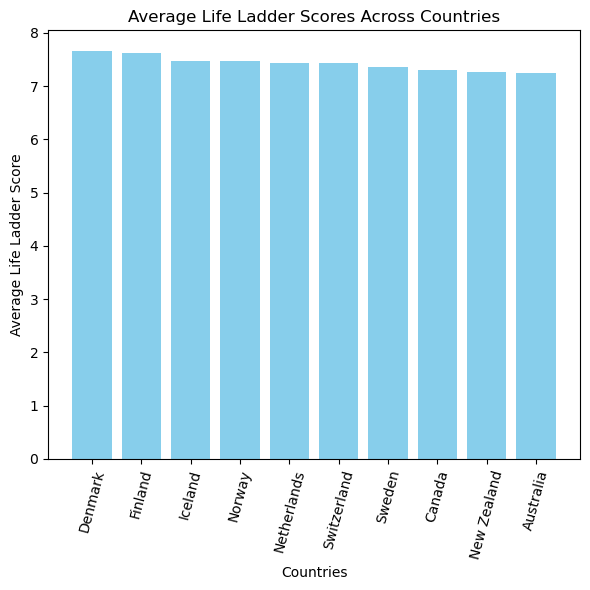

In [45]:
# Bar chart to compare average scores of "Life Ladder" across countries. 

# Calculate average scores
average_scores = table_df.groupby('Country name')['Life Ladder'].mean().reset_index()

max_10_countries = average_scores.sort_values(by='Life Ladder', ascending=False).head(10)

#Creating the bar chart top 10
x_value = max_10_countries['Country name']
y_value = max_10_countries['Life Ladder']

plt.figure(figsize=(6,6))
plt.bar( x_value, y_value, color='skyblue')
plt.xlabel('Countries')
plt.ylabel('Average Life Ladder Score')
plt.title('Average Life Ladder Scores Across Countries')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


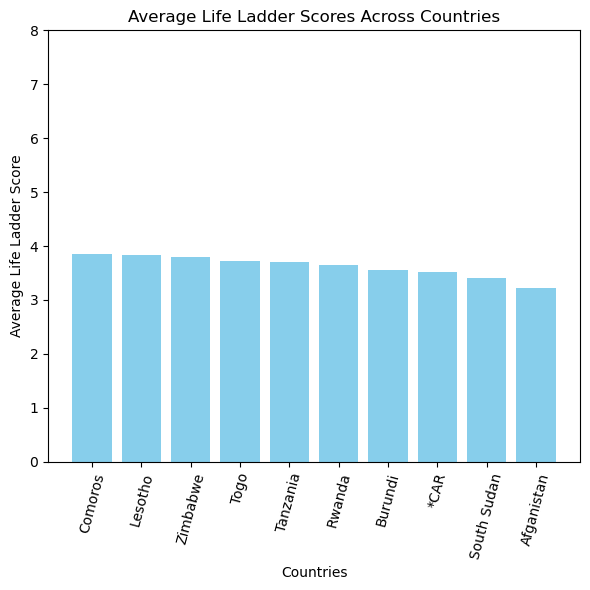

In [59]:
# Bar chart to compare average scores of "Life Ladder"  across countries. 

# Calculate average scores
average_scores = table_df.groupby('Country name')['Life Ladder'].mean().reset_index()

min_10_countries = average_scores.sort_values(by='Life Ladder', ascending=True).head(10)
min_10_countries_sorted = min_10_countries.sort_values(by='Life Ladder', ascending=False)

#Creating the bar chart top 10
x_value = min_10_countries_sorted['Country name']
y_value = min_10_countries_sorted['Life Ladder']

plt.figure(figsize=(6,6))
plt.bar( x_value, y_value, color='skyblue')
plt.xlabel('Countries')
plt.ylabel('Average Life Ladder Score')
plt.title('Average Life Ladder Scores Across Countries')
# Custom x-axis label
custom_label= ['Comoros', 'Lesotho', 'Zimbabwe','Togo', 'Tanzania', 'Rwanda', 'Burundi', '*CAR', 'South Sudan', 'Afganistan']
plt.xticks(ticks=range(len(custom_label)), labels = custom_label, rotation=75)
# plt.xticks(rotation=60)
plt.ylim(0.0, 8.0)
plt.tight_layout()
plt.show()